In [19]:
import numpy as np
import scipy as sc
import scipy.io
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline
import json

plt.rcParams['text.usetex'] = True
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.titlesize'] = 22
plt.rcParams['axes.labelsize'] = 20
plt.rcParams['legend.fontsize'] = 18

from sklearn.linear_model import LinearRegression

from qpfs import *

lr = LinearRegression()

In [20]:
def score_vs_alpha3(qpfs, mode, alpha3_array):
        
    alphas_history = []
    score_history = []
    for alpha3 in tqdm_notebook(alpha3_array):
        alphas = qpfs.get_alpha(mode, alpha3)
        qpfs.solve_problem(alphas, mode)
        alphas_history.append(alphas)
        score_history.append((qpfs.zx, qpfs.zy))
    return score_history, alphas_history

In [21]:
def get_autoreg_Y(Y, step=1):
    m, t = Y.shape
    ar = np.zeros((m - step + 1, t * step))
    for i in range(step):
        for k in range(t):
            ar[:, i * t + k] = Y[i: m + i - step + 1, k]

    return ar

a = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 9]])
get_autoreg_Y(a, step=3)

array([[ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.]])

In [22]:
def plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, alpha=None, 
                           figsize=(6.5, 4), legend_disable=False):

    plt.figure(figsize=figsize)

    prev = 0.
    for i in range(n_y):
        cur = [np.sum(sh[1][:i + 1]) for sh in score_history]
        plt.plot(alpha3_array, cur, c='k', linewidth=1.)
        plt.fill_between(alpha3_array, cur, prev, alpha=0.15, edgecolor='k', 
                         label=r'{}'.format('$\mathbf{z}_{y,' + str(i + 1) + '}$'))
        prev = cur

    plt.ylim(0., 1.)
    plt.xlim(0., 1.)
    
    if alpha is not None:
        plt.axvline(x=alpha, c='k')
    
    if legend_disable:
        bea = ()
    else:
        lgd = plt.legend(bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
                   ncol=n_y, mode="expand", borderaxespad=0., frameon=True, handletextpad=0.15)
        bea = (lgd,)
    
    plt.xlabel(r'$\alpha_3$')
    plt.tight_layout()
    plt.savefig(f'figs/features_vs_alpha_ecog_{n_y}.pdf', format='pdf', bbox_extra_artists=bea, bbox_inches='tight')
    plt.show()

In [23]:
Xtrain = sc.io.loadmat('./../data/ECoG_X_train.mat')['X_train'].reshape([-1, 32 * 27])
Ytrain = sc.io.loadmat('./../data/ECoG_Y_train.mat')['Y_train']

Xtest = sc.io.loadmat('./../data/ECoG_X_test.mat')['X_hold_out'].reshape([-1, 32 * 27])
Ytest = sc.io.loadmat('./../data/ECoG_Y_test.mat')['Y_hold_out']

n_samples, n_features = Xtrain.shape

print(Xtrain.shape, Ytrain.shape)
print(Xtest.shape, Ytest.shape)

(12801, 864) (12801, 3)
(6087, 864) (6087, 3)


## Step = 1

In [24]:
mode='SymImp'

mqpfs = MultivariateQPFS()
mqpfs.get_params(Xtrain, Ytrain)
alphas = mqpfs.get_alpha(mode='SymImp')
alphas

array([ 0.15678164,  0.77998418,  0.06323418])

In [25]:
mode = 'SymImp'

alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_history = score_vs_alpha3(mqpfs, mode, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_1.npy', np.array(score_history))

A Jupyter Widget

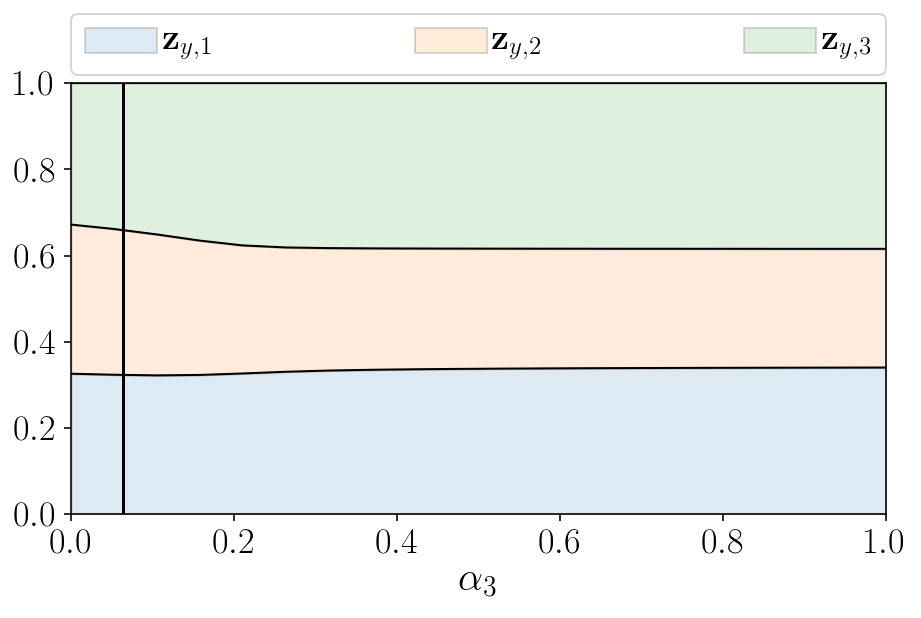

In [26]:
score_history = np.load('res/features_vs_alpha_ecog_3_1.npy')
alpha3_array = np.linspace(0, 1, 20)

n_x, n_y = Xtrain.shape[1], Ytrain.shape[1] 

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, alpha=alphas[-1])

## Step = 2

In [27]:
step = 2

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

(12800, 6) (12800, 864) (6086, 6) (6086, 864)


In [28]:
mqpfs.get_params(Xtrain_ar, Ytrain_ar)
alphas = mqpfs.get_alpha(mode='SymImp')
alphas

array([ 0.1567329 ,  0.77986225,  0.06340485])

In [29]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_array = score_vs_alpha3(mqpfs, mode, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_{}.npy'.format(step), np.array(score_history))

A Jupyter Widget

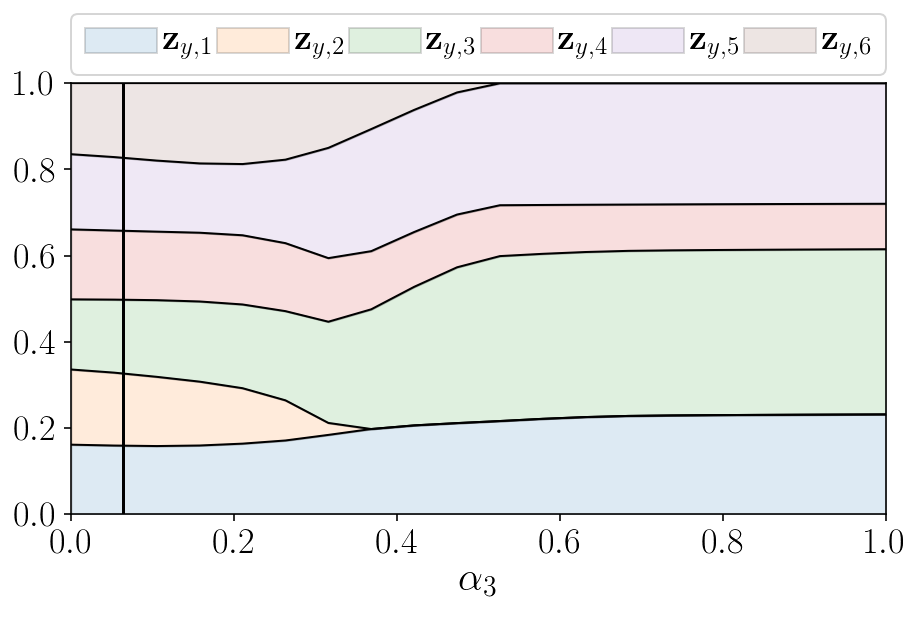

In [30]:
score_history = np.load('res/features_vs_alpha_ecog_3_{}.npy'.format(step))
alpha3_array = np.linspace(0, 1, 20)

n_x, n_y = Xtrain_ar.shape[1], Ytrain_ar.shape[1]

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, alpha=alphas[-1])

## Step = 3

In [32]:
step = 3

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

mqpfs.get_params(Xtrain_ar, Ytrain_ar)
alphas = mqpfs.get_alpha(mode='SymImp')
alphas

(12799, 9) (12799, 864) (6085, 9) (6085, 864)


array([ 0.15673997,  0.77954279,  0.06371724])

In [33]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_array = score_vs_alpha3(mqpfs, mode, alpha3_array)

np.save('res/features_vs_alpha_ecog_3_{}.npy'.format(step), np.array(score_history))

A Jupyter Widget

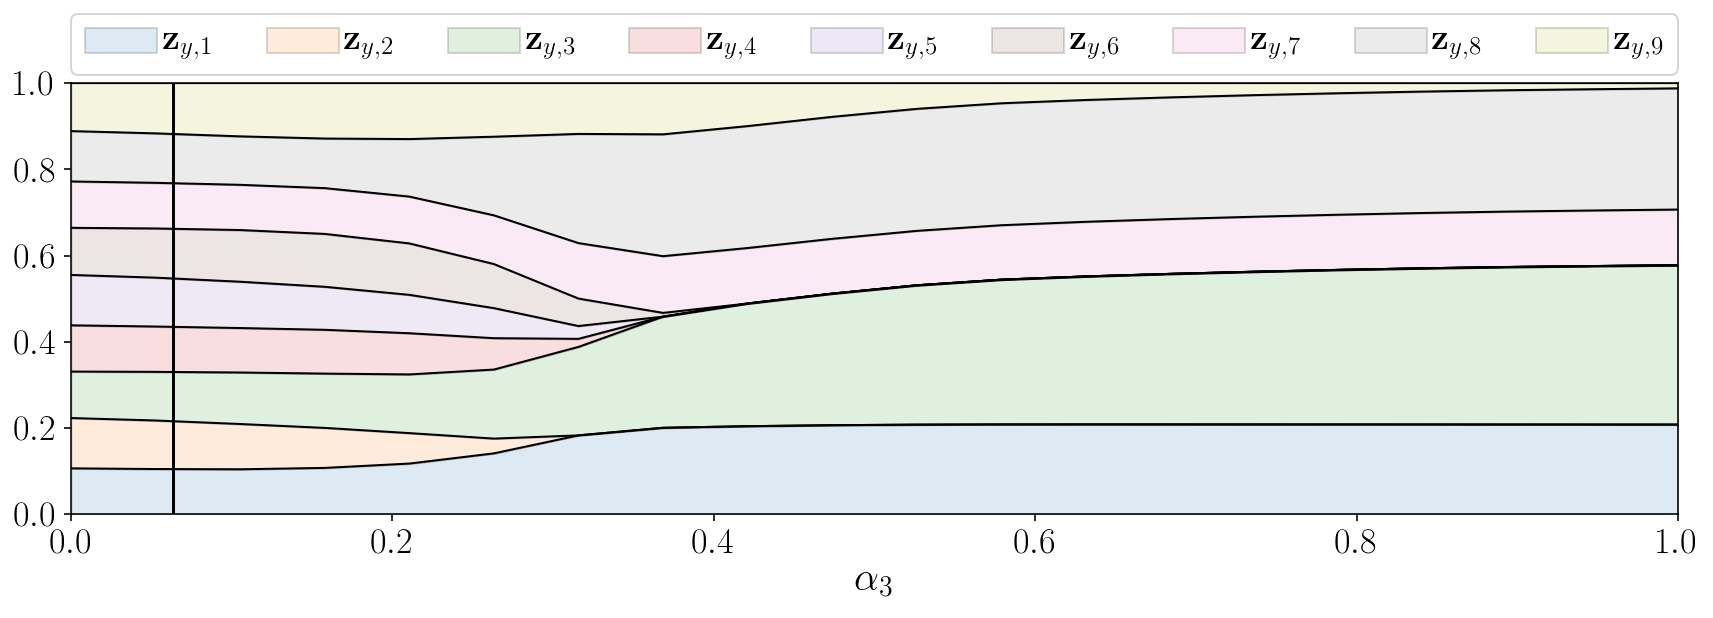

In [34]:
score_history = np.load('res/features_vs_alpha_ecog_3_{}.npy'.format(step))
alpha3_array = np.linspace(0, 1, 20)

n_x, n_y = Xtrain_ar.shape[1], Ytrain_ar.shape[1]

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, alpha=alphas[-1], 
                       figsize=(12, 4))

## Step = 15

In [39]:
step = 15

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

mqpfs.get_params(Xtrain_ar, Ytrain_ar)
alphas = mqpfs.get_alpha()
alphas

(12787, 45) (12787, 864) (6073, 45) (6073, 864)


array([ 0.15157264,  0.77851907,  0.06990829])

In [40]:
alpha3_array = np.linspace(0, 1, 20)
score_history, alphas_history = score_vs_alpha3(mqpfs, mode, alpha3_array)

#np.save('res/features_vs_alpha_ecog_3_{}.npy'.format(step), np.array(score_history))

A Jupyter Widget

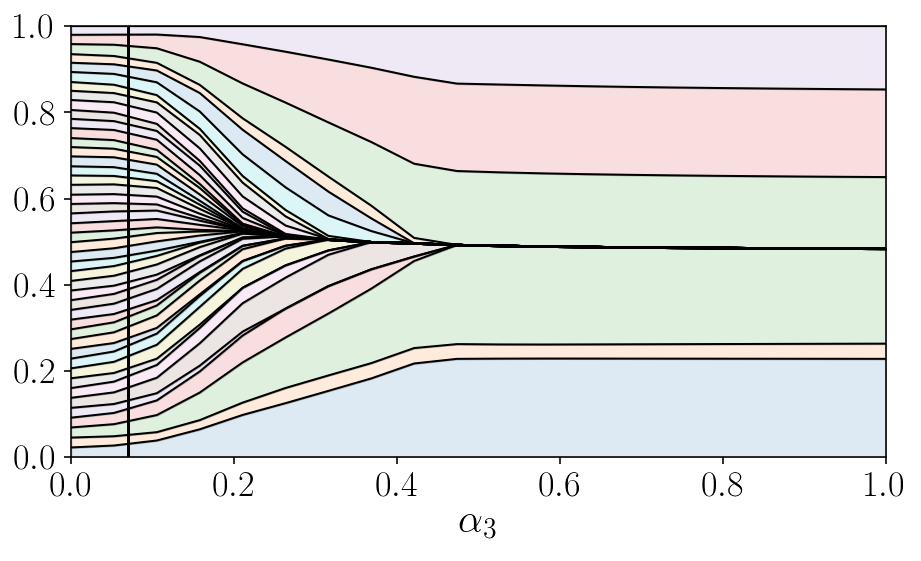

In [41]:
#score_history = np.load('res/features_vs_alpha_ecog_3_{}.npy'.format(step))
alpha3_array = np.linspace(0, 1, 20)

n_x, n_y = Xtrain_ar.shape[1], Ytrain_ar.shape[1]

plot_features_vs_alpha(n_x, n_y, alpha3_array, score_history, alpha=alphas[-1],
                       figsize=(6.5, 4), legend_disable=True)

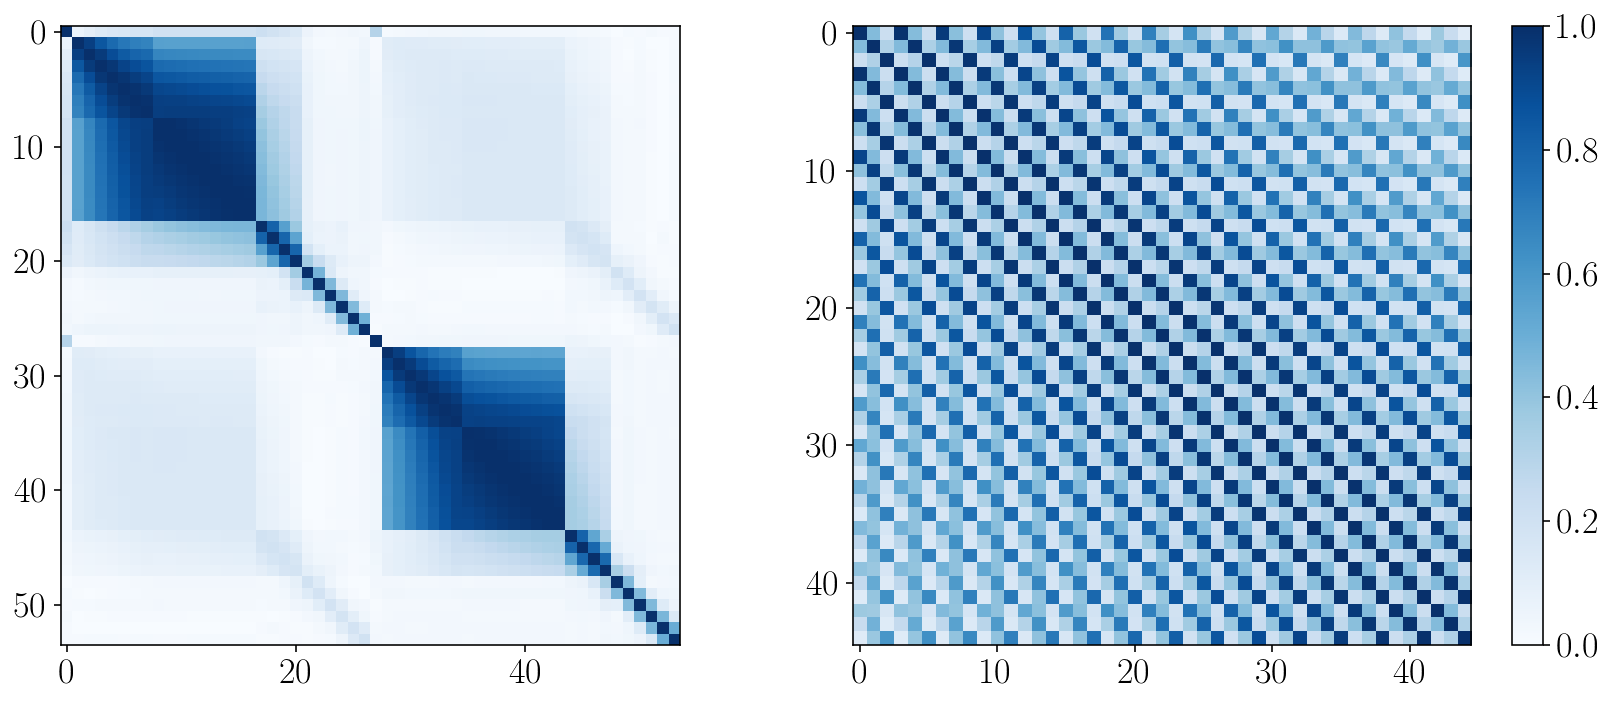

In [28]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.imshow(np.abs(get_corr_matrix(Xtrain_ar[:, :54])), vmin=0., vmax=1., cmap='Blues')
#plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.abs(get_corr_matrix(Ytrain_ar)), vmin=0., vmax=1., cmap='Blues')
plt.colorbar()
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('figs/corr_matrix.eps', format='eps')
plt.show()

(12790, 36) (12790, 864) (6076, 36) (6076, 864)


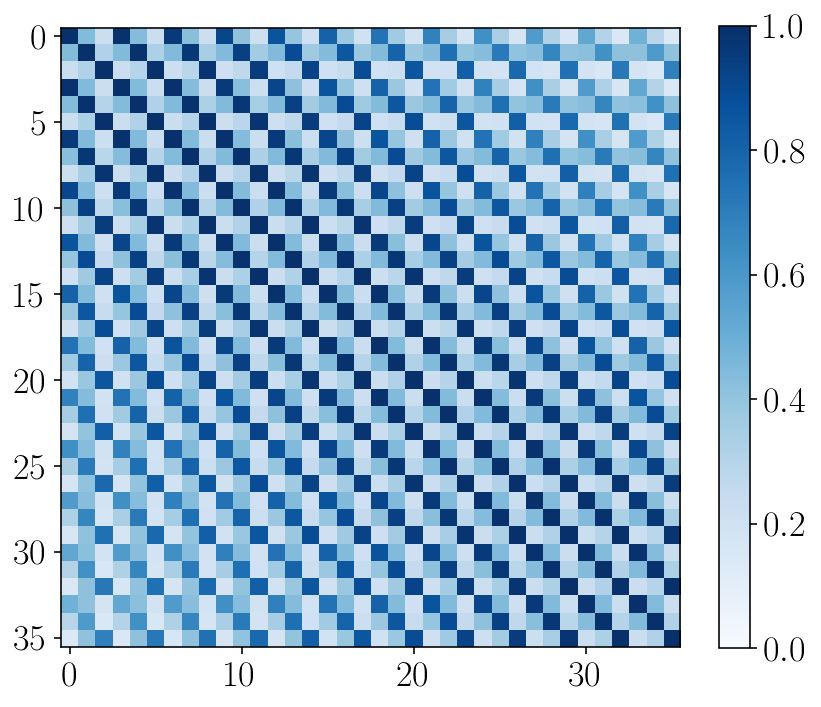

In [26]:
step = 12

Ytrain_ar, Ytest_ar = get_autoreg_Y(Ytrain, step), get_autoreg_Y(Ytest, step)
Xtrain_ar, Xtest_ar = Xtrain[:Xtrain.shape[0]-step + 1], Xtest[:Xtest.shape[0]-step + 1]

print(Ytrain_ar.shape, Xtrain_ar.shape, Ytest_ar.shape, Xtest_ar.shape)

plt.figure(figsize=(6, 5))
plt.imshow(np.abs(get_corr_matrix(Ytrain_ar)), vmin=0., vmax=1., cmap='Blues')
plt.colorbar()
plt.tight_layout()
plt.subplots_adjust()
plt.savefig('figs/Y_corr_matrix.eps', format='eps')
plt.show()